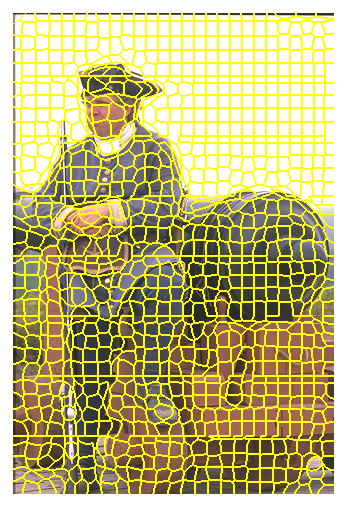

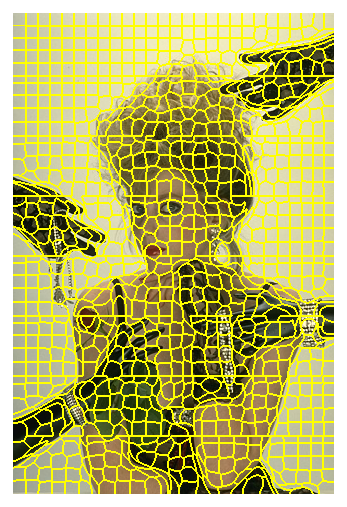

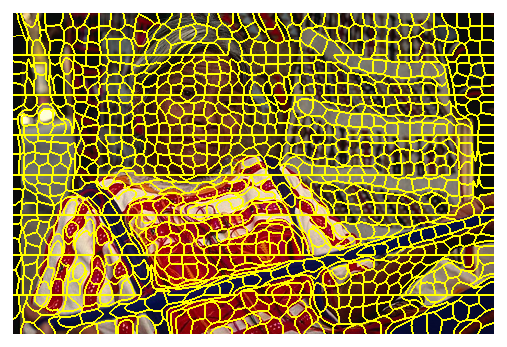

In [18]:
# USAGE
# MR-SLIC_original
from pyspark.context import SparkContext
from skimage.segmentation import mark_boundaries
from skimage import io
import collections as coll
import time
from scipy import ndimage as ndi
from skimage.segmentation import slic
from PIL import Image
from skimage.util import img_as_float
import numpy as np
from skimage.segmentation._slic_master import _slic_cythonM
from skimage.segmentation._slic import _enforce_label_connectivity_cython
from skimage.color import rgb2lab
import os

#number of overlap(0, 20, 40, 60, 80)
overlap =10
#목표 세그먼트
OriginSegments = 1000
folder = 'test'


path = "/home/gangmin/experiment/data/images/"+folder
file_list = os.listdir(path)
file_list_img = [file for file in file_list if file.endswith(".jpg")]

#split size
# 폴더는 overlap+1
#number of partition
partition = 8
# 이미지 조각당 세그먼트 수 
numSegments = (OriginSegments//8)
testnum = 0
for img_name in file_list_img:
    
    name = img_name[:-4]
    #원본 이미지 메타데이터(결과 출력용)
    images = Image.open(path+'/'+img_name)
    #원본 이미지 크기
    (img_w,img_h) = images.size
    depth = 1

    
    #ilist 생성
    size = images.size
    temp = size[1]//partition
    remain = size[1]%partition
    split_list =[]
    for i in range(partition):
        split_list.insert(0,temp)
        if remain is not 0:
            split_list[0] = split_list[0]+1
            remain -=1
    index = 0
    listi = []
    for i in range(partition):
        listi.append(index)
        index += split_list[i]
    #percent
    percent = int(overlap/2)
    #file list
    k=[]
    for i in range(partition):
        if i==0 or i == partition-1:
            k.append([name+'_'+str(i),percent])
        else:
            k.append([name+'_'+str(i),percent*2])
    
    
    #이미지를 float으로 변환
    images = img_as_float(images)
    #map 함수
    def Map(k):
        #time check
        start_time = time.time()


        #read imagez
        #submit image with job 
        img = Image.open('/home/gangmin/experiment/data/overlap_images/'+folder+'/'+str(overlap)+'/'+ k[0] +'.jpg')

        image = img_as_float(img)
        #슬레이브 노드로 작업 분배
        #각 노드에서 이미지 읽고 작업
        segments,distances = slic(image, n_segments = int(numSegments*(100+k[1])/100), sigma = 5)
        #segments(lable(nesre_segments))데이터와 distance 데이터를 둘다 받는다.


        finish_time = time.time()
        #k 로 1,2,3 숫자 받는다.
        return segments, distances, start_time, finish_time, k[0][-1]
    #times, segments, distances 를 리턴받는다.
    stime = time.time()
    datas = sc.parallelize(k,partition).map(Map).collect()
    
    ftime = time.time()

     
    

    #원본 이미지 메타데이터로 dimension 전송
    dimension = [depth,img_h,img_w]
    dimension = np.ascontiguousarray(dimension)

    
    
    
    #segments, distances 리스트 만들기
    indlist = [[],[]]
    tempindex = 0
    for i in datas:
        
        indlist[0] += [int(i[4])+1]
        indlist[1].append(i[0][np.newaxis,:][0].shape[0])
        if tempindex is 0:
            seg_array = i[0][np.newaxis,:][0]
            dist_array = i[1][0]
        else:
            seg_array = np.r_[seg_array,i[0][np.newaxis,:][0]]
            dist_array = np.r_[dist_array,i[1][0]]
        
        tempindex +=1
    
    # array broadcast 불가 -> 합쳐서 전송하고 다시 분리    
    # 분리할때 인덱스대로 분리하고 겉에 []를 씌워줘서 3차원 형태로 만들어야함
    #바뀐점은 한줄로 펴진 array형태로 전달하고, indlist에서 한차원 늘어남.
    
    
    #slic_master (cython 부분)
    nearest_segmentsO \
        = np.empty((depth, img_h, img_w), dtype=np.intp)
    distanceO \
        = np.empty((depth, img_h, img_w), dtype=np.double)
    distanceO[:, :, :] = np.full((depth, img_h, img_w), 999, dtype=np.double)
    n_node = np.array(indlist[0]).shape[0]
   

    #extension = int(split_list[i]*percent/100)    
    import math
    temp_boundary = int(math.sqrt((img_h*img_w)/OriginSegments)//2)
    
    for i in range(n_node):
        indlist[0][i] = listi[indlist[0][i]-1]
    
    '''
    overlap 0일경우 코드 수정ㅎ가ㅣ
    ##########################################333
    ############################################
    #########################################
    '''
    if overlap !=0:
        #새로운 코드
        #cython 코드 짤 때 가변성 없얘기
        temp = 0
        empty =[]
        boundary = np.array(empty)
        for i in range(0,n_node):
            z_min = 0
            y_min = indlist[0][i]
            extension = int(split_list[i]*int(overlap/2)/100) 
            for z in range(z_min,z_min+1):
                for y in range(max(0,y_min-temp_boundary),min(img_h,y_min+split_list[i]+temp_boundary)):
                    for x in range(0, img_w):
                        if i == 0:
                            distanceO[z,y,x] = dist_array[y,x]
                            nearest_segmentsO[z,y,x] = seg_array[y,x]
                        else:
                            if (y>=y_min-temp_boundary and y<y_min + temp_boundary) and nearest_segmentsO[z,y,x] in boundary:

                                pass
                                #nearest_segmentsO[z,y,x] = 999
                            else:
                                distanceO[z,y,x] = dist_array[temp+y-y_min+extension,x]
                                nearest_segmentsO[z,y,x] = seg_array[temp+y-y_min+extension,x]
                        if   i!= n_node-1 and y == y_min+split_list[i]-temp_boundary:
                            if x ==0:
                                #초기화
                                boundary = np.array(empty)
                            boundary = np.append(boundary,nearest_segmentsO[z,y,x])

            if i==0:
                temp += indlist[1][i]
            else:
                temp += indlist[1][i]

        result = nearest_segmentsO
        
        #label 결속 처리
        if 1:
            segment_size = depth * img_h * img_w / OriginSegments
            min_size = int(0.5 * segment_size)
            max_size = int(3 * segment_size)
            labels = _enforce_label_connectivity_cython(result,min_size,max_size)
    else:   
        labels = seg_array[np.newaxis,:]
    fftime = time.time()

    
    
    
    
    #time check
    import pandas as pd
    data = pd.DataFrame(columns=['node','time'])
    number = 0
    node = 1
    datat = pd.DataFrame(columns=['node','time'])
    pd.options.display.float_format = '{:.6f}'.format
    for i in datas:
        datat.loc[number]=['node '+str(node),i[3]-i[2]]

        data.loc[number]=['node '+str(node)+' start',i[2]]
        number += 1
        data.loc[number]=['node '+str(node)+' finish',i[3]]
        number += 1
        node+=1
    data = data.sort_values(by=['time'], axis=0)


    
    
    
    
    import matplotlib.pyplot as plt
    #save result
    fig = plt.figure("Superpixels -- %d segments" % (OriginSegments),dpi = 96,figsize = (img_w/96,img_h/96))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(mark_boundaries(images, labels[0]))
    plt.xticks([]), plt.yticks([])
    plt.tight_layout()
    plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, hspace = 0, wspace = 0)

    #plt.savefig('/home/gangmin/image-resource/result.png',bbox_inces='tight',pad_inches=0)

    plt.axis("off")

    # show the plots
    plt.show()
    
    #df = pd.DataFrame(labels[0])
    #df.to_csv('/home/gangmin/experiment/mrslic/exp2/'+folder+'/'+str(overlap)+'/'+img_name[:-4]+".csv",header=None,index=None)
    
    testnum +=1
    if testnum == 3:
        break
    


(481, 321)
[0, 9, 18, 27, 36, 45, 54, 63, 72, 81, 90, 99, 108, 117, 126, 135, 144, 153, 162, 171, 180, 189, 198, 207, 216, 225, 234, 243, 252, 261, 270, 279, 288, 297, 306, 315, 324, 333, 342, 351, 360, 369, 378, 387, 396, 405, 414, 423, 432, 441, 450, 459, 468, 481]
[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 13]
[7, 7, 7, 7, 7, 6, 6, 6]
53
36
[[ 0 , 63 ],[ 63 , 126 ],[ 126 , 189 ],[ 189 , 252 ],[ 252 , 315 ],[ 315 , 369 ],[ 369 , 423 ],[ 423 , 481 ]]

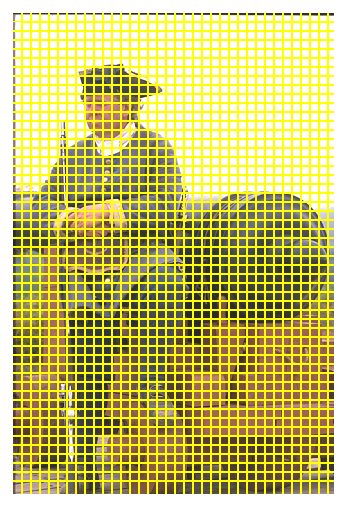

(481, 321)
[0, 9, 18, 27, 36, 45, 54, 63, 72, 81, 90, 99, 108, 117, 126, 135, 144, 153, 162, 171, 180, 189, 198, 207, 216, 225, 234, 243, 252, 261, 270, 279, 288, 297, 306, 315, 324, 333, 342, 351, 360, 369, 378, 387, 396, 405, 414, 423, 432, 441, 450, 459, 468, 481]
[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 13]
[7, 7, 7, 7, 7, 6, 6, 6]
53
36
[[ 0 , 63 ],[ 63 , 126 ],[ 126 , 189 ],[ 189 , 252 ],[ 252 , 315 ],[ 315 , 369 ],[ 369 , 423 ],[ 423 , 481 ]]

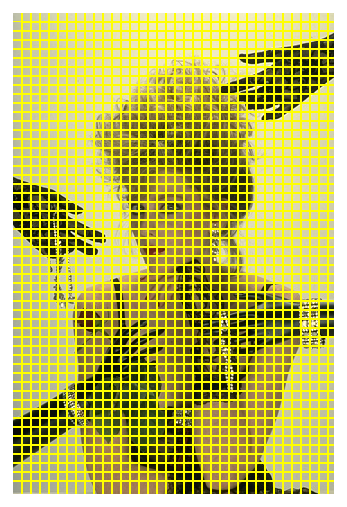

(321, 481)
[0, 9, 18, 27, 36, 45, 54, 63, 72, 81, 90, 99, 108, 117, 126, 135, 144, 153, 162, 171, 180, 189, 198, 207, 216, 225, 234, 243, 252, 261, 270, 279, 288, 297, 306, 315, 321]
[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 6]
[5, 5, 5, 5, 4, 4, 4, 4]
36
53
[[ 0 , 45 ],[ 45 , 90 ],[ 90 , 135 ],[ 135 , 180 ],[ 180 , 216 ],[ 216 , 252 ],[ 252 , 288 ],[ 288 , 321 ]]

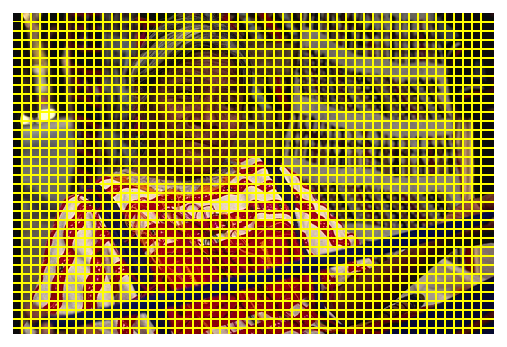

In [21]:
# USAGE
# python2.7 superpixel.py --image raptors.png

# import the necessary packages
from skimage.segmentation.slic_superpixelsO import slicO
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
import matplotlib.pyplot as plt
import argparse
from PIL import Image
import sys

## construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()

# ap.add_argument("-i", "--image", required = True, help = "Path to the image")
# args = vars(ap.parse_args())
## load the image and convert it to a floating point data type
# image = img_as_float(io.imread(args["image"]))

#path of image
#impath = sys.argv[1]


path = "/home/gangmin/experiment/data/images/test"
file_list = os.listdir(path)
file_list_img = [file for file in file_list if file.endswith(".jpg")]


# loop over the number of segments
numSegments = 2000
tempnum = 0
for img_name in file_list_img:
    
    name = img_name[:-4]
    
    #read image
    img = Image.open(path +'/'+ name+ '.jpg')

    image = img_as_float(img)
    #print(image)
    (img_w,img_h) = img.size
    
    
    
    segments = slicO(image, n_segments = numSegments, sigma = 5)
    print(segments.shape)
    
    
    
    
    
    
    #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    # image split list 생성
    #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    
    init_list = []
    dist_list = []
    for i,v in enumerate(segments):
        if i==0:
            seg_w = len(np.unique(v))
        if v[0] not in init_list:
            init_list.append(v[0])
            dist_list.append(i)
    #ilist 생성
    partition = 8
    height = len(init_list)
    temp = height//partition
    remain = height%partition
    split_list =[]
    for i in range(partition):
        split_list.insert(0,temp)
        if remain is not 0:
            split_list[0] = split_list[0]+1
            remain -=1
    index = 0
    split_list.sort(reverse=True)
    for i in range(partition):
        index += split_list[i]
    
    index = 0
    dist_list.append(img_h)
    

    print(dist_list)
    di_list=[]
    for i in range(1,len(dist_list)):
        di_list.append(dist_list[i]-dist_list[i-1])
    print(di_list)
    print(split_list)
    
    
    seg_h = sum(split_list)
    print(seg_h)
    print(seg_w)
    
    
    print("[",end="")
    for e,i in enumerate(split_list):
        first = dist_list[index]
        index += i
        last = dist_list[index]
        print("[",first,",", last,"]",end="")
        if e != len(split_list)-1:
            print(",",end="")
        else:
            print("]",end="")
        
        
    #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

    
    # show the output of SLIC
    fig = plt.figure("Superpixels -- %d segments" % (numSegments),dpi = 96,figsize = (img_w/96,img_h/96))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(mark_boundaries(image, segments))
    plt.xticks([]), plt.yticks([])
    plt.tight_layout()
    plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, hspace = 0, wspace = 0)
    plt.axis("off")
    plt.show()
    
    tempnum +=1
    if tempnum == 3:
        break